## Dependencies

In [1]:
import os
import sys
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Input

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)

seed = 0
seed_everything(seed)
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import *

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Load data

In [2]:
hold_out_set = pd.read_csv('../input/aptos-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', X_train.shape[0])
print('Number of validation samples: ', X_val.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
X_train["id_code"] = X_train["id_code"].apply(lambda x: x + ".png")
X_val["id_code"] = X_val["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
display(X_train.head())

Number of train samples:  2929
Number of validation samples:  733
Number of test samples:  1928


,id_code,diagnosis,height,width,set
0,55eac26bd383.png,1,1736,2416,train
1,44e0d56e9d42.png,2,2136,3216,train
2,aa4407aab872.png,0,1050,1050,train
3,cffc50047828.png,0,614,819,train
4,b0f0fa677d5f.png,0,1050,1050,train


# Model parameters

In [3]:
# Model parameters
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
TTA_STEPS = 1 # No TTA

weights_path = '../input/effnetb5-1/effNetB5_img224.h5'
size_list = [224, 232, 240, 248, 256]

In [4]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()
    
def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(np.append(train_preds, validation_preds), np.append(train_labels, validation_labels), weights='quadratic'))

def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

def ensemble_preds(model_list, generator, dataframe, size_list):
    preds_ensemble = []
    for index, model in enumerate(model_list):
        img_size = size_list[index]
        generator = datagen.flow_from_dataframe(
                            dataframe=dataframe,
                            directory=generator.directory,
                            x_col="id_code",
                            y_col="diagnosis",
                            class_mode=generator.class_mode,
                            batch_size=generator.batch_size,
                            shuffle=generator.shuffle,
                            target_size=(img_size, img_size),
                            seed=generator.seed)
        generator.reset()
        preds = model.predict_generator(generator, steps=generator.n)
        preds_ensemble.append(preds)

    return np.mean(preds_ensemble, axis=0)

def apply_tta(model, generator, steps=5):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

def test_ensemble_preds(model_list, generator, dataframe, size_list, steps=5):
    preds_ensemble = []
    for index, model in enumerate(model_list):
        img_size = size_list[index]
        generator = datagen.flow_from_dataframe(
                            dataframe=dataframe,
                            directory=generator.directory,
                            x_col="id_code",
                            class_mode=generator.class_mode,
                            batch_size=generator.batch_size,
                            shuffle=generator.shuffle,
                            target_size=(img_size, img_size),
                            seed=generator.seed)
        preds = apply_tta(model, generator, steps)
        preds_ensemble.append(preds)

    return np.mean(preds_ensemble, axis=0)

# Pre-procecess images

In [5]:
new_data_base_path = '../input/aptos2019-blindness-detection/train_images/'
test_base_path = '../input/aptos2019-blindness-detection/test_images/'
train_dest_path = 'base_dir/train_images/'
validation_dest_path = 'base_dir/validation_images/'
test_dest_path =  'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_dest_path)
os.makedirs(validation_dest_path)
os.makedirs(test_dest_path)

def crop_image(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            
        return img

def circle_crop(img):
    img = crop_image(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = width//2
    y = height//2
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image(img)

    return img
        
def preprocess_image(image_id, base_path, save_path, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = circle_crop(image)
    image = cv2.resize(image, (HEIGHT, WIDTH))
#     image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 , 128)
    cv2.imwrite(save_path + image_id, image)
        
def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    df = df.reset_index()
    for i in range(df.shape[0]):
        item = df.iloc[i]
        image_id = item['id_code']
        item_set = item['set']
        if item_set == 'train':
            preprocess_image(image_id, new_data_base_path, train_dest_path)
        if item_set == 'validation':
            preprocess_image(image_id, new_data_base_path, validation_dest_path)
        
def preprocess_test(df, base_path=test_base_path, save_path=test_dest_path, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    df = df.reset_index()
    for i in range(df.shape[0]):
        image_id = df.iloc[i]['id_code']
        preprocess_image(image_id, base_path, save_path)

n_cpu = mp.cpu_count()
train_n_cnt = X_train.shape[0] // n_cpu
val_n_cnt = X_val.shape[0] // n_cpu
test_n_cnt = test.shape[0] // n_cpu

# Pre-procecss old data train set
pool = mp.Pool(n_cpu)
dfs = [X_train.iloc[train_n_cnt*i:train_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = X_train.iloc[train_n_cnt*(n_cpu-1):]
res = pool.map(preprocess_data, [x_df for x_df in dfs])
pool.close()

# Pre-procecss validation set
pool = mp.Pool(n_cpu)
dfs = [X_val.iloc[val_n_cnt*i:val_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = X_val.iloc[val_n_cnt*(n_cpu-1):] 
res = pool.map(preprocess_data, [x_df for x_df in dfs])
pool.close()

# Pre-procecss test set
pool = mp.Pool(n_cpu)
dfs = [test.iloc[test_n_cnt*i:test_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = test.iloc[test_n_cnt*(n_cpu-1):] 
res = pool.map(preprocess_test, [x_df for x_df in dfs])
pool.close()

# Data generator

In [6]:
datagen=ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
                        dataframe=X_train,
                        directory=train_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=1,
                        shuffle=False,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)

valid_generator=datagen.flow_from_dataframe(
                        dataframe=X_val,
                        directory=validation_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=1,
                        shuffle=False,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)

test_generator=datagen.flow_from_dataframe(  
                       dataframe=test,
                       directory=test_dest_path,
                       x_col="id_code",
                       batch_size=1,
                       class_mode=None,
                       shuffle=False,
                       target_size=(HEIGHT, WIDTH),
                       seed=seed)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Found 1928 validated image filenames.


# Model

In [7]:
def create_model(input_shape, weights_path):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB5(weights=None, 
                                include_top=False,
                                input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    final_output = Dense(1, activation='linear', name='final_output')(x)
    model = Model(input_tensor, final_output)
    model.load_weights(weights_path)
    
    return model

In [8]:
model_list = []

for img_size in size_list:
    model_list.append(create_model(input_shape=(img_size, img_size, CHANNELS), weights_path=weights_path))

In [9]:
# Train predictions
preds_ensemble = ensemble_preds(model_list, train_generator, X_train, size_list)
preds_ensemble = [classify(x) for x in preds_ensemble]
train_preds = pd.DataFrame({'label':train_generator.labels, 'pred':preds_ensemble})

# Validation predictions
preds_ensemble = ensemble_preds(model_list, valid_generator, X_val, size_list)
preds_ensemble = [classify(x) for x in preds_ensemble]
validation_preds = pd.DataFrame({'label':valid_generator.labels, 'pred':preds_ensemble})

Found 2929 validated image filenames.
Found 2929 validated image filenames.
Found 2929 validated image filenames.
Found 2929 validated image filenames.
Found 2929 validated image filenames.
Found 733 validated image filenames.
Found 733 validated image filenames.
Found 733 validated image filenames.
Found 733 validated image filenames.
Found 733 validated image filenames.


# Model Evaluation

## Confusion Matrix

### Original thresholds

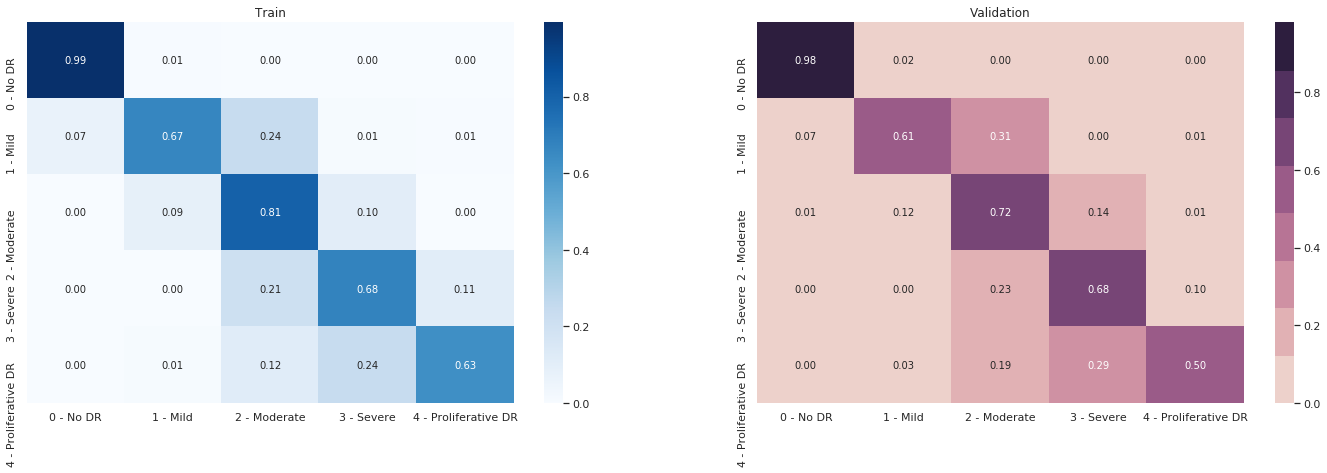

In [10]:
plot_confusion_matrix((train_preds['label'], train_preds['pred']), (validation_preds['label'], validation_preds['pred']))

## Quadratic Weighted Kappa

In [11]:
evaluate_model((train_preds['label'], train_preds['pred']), (validation_preds['label'], validation_preds['pred']))

Train        Cohen Kappa score: 0.946
Validation   Cohen Kappa score: 0.912
Complete set Cohen Kappa score: 0.939


## Apply model to test set and output predictions

In [12]:
preds = test_ensemble_preds(model_list, test_generator, test, size_list, TTA_STEPS)
predictions = [classify(x) for x in preds]

results = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

Found 1928 validated image filenames.
Found 1928 validated image filenames.
Found 1928 validated image filenames.
Found 1928 validated image filenames.
Found 1928 validated image filenames.


In [13]:
# Cleaning created directories
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)

# Predictions class distribution

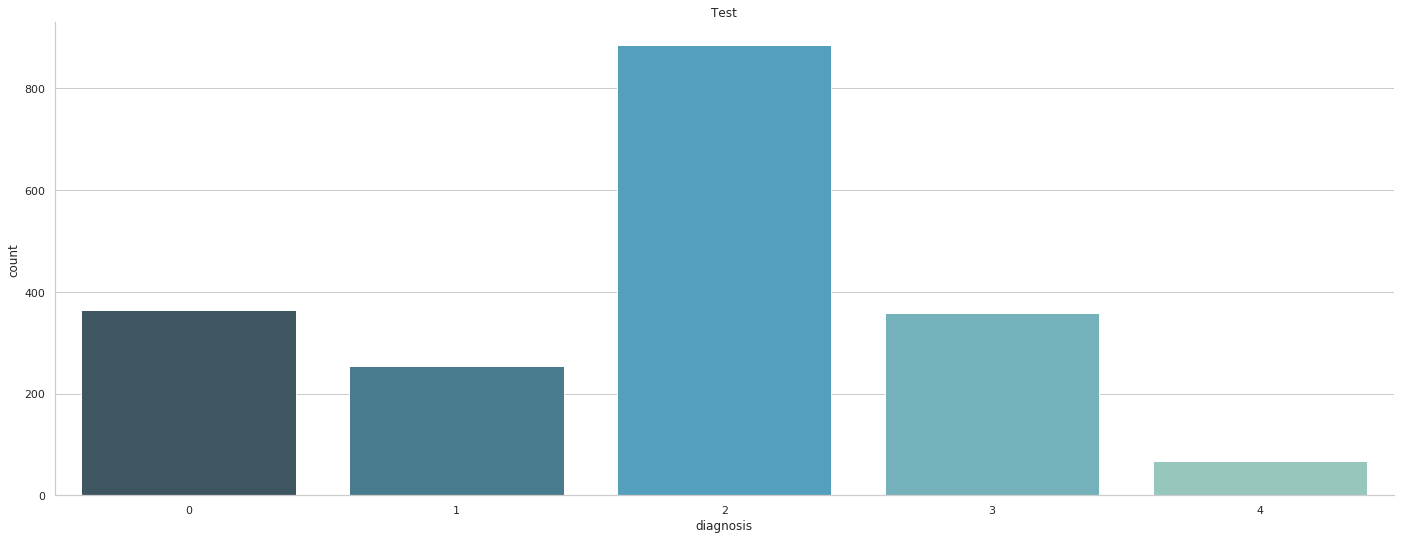

In [14]:
fig = plt.subplots(sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d").set_title('Test')
sns.despine()
plt.show()

In [15]:
results.to_csv('submission.csv', index=False)
display(results.head())

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,3
